In [ ]:
import numpy as np #匯入numpy模組，用於陣列計算
import pandas as pd #匯入pandas模組，數據分析模組，提供三種資料結構供使用：Series、DataFrame、Panel
import tensorflow as tf #由Google開發，是現今重要的深度學習框架之一
import tensorflow.keras.backend as K #keras後端是tensorflow和Theano，Keras模塊能夠同時在Theano和TensorFlow兩個框架上使用
import random #匯入亂數模組
from tensorflow.keras.callbacks import ReduceLROnPlateau #調整學習率的函數
from sklearn.model_selection import KFold #KFold是常見的交叉驗證方法
import os #匯入os模組，與作業系統互動的模組
for dirname, _, filenames in os.walk('/kaggle/input'): #把資料夾路徑和檔名串接起來
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

In [ ]:
def seed_everything(seed=42): #設置隨機數種子
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed) 
    tf.random.set_seed(seed)
    
seed_everything(42)

In [ ]:
#讀取 CSV File
train_features = pd.read_csv("/kaggle/input/lish-moa/train_features.csv")
train_targets = pd.read_csv("/kaggle/input/lish-moa/train_targets_scored.csv")
test_features = pd.read_csv("/kaggle/input/lish-moa/test_features.csv")
sample_submission = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")

In [ ]:
train_targets.head()

In [ ]:
sample_submission.head()

In [ ]:
#訓練集檔案
train_features.head()
#23814 rows × 876 columns

In [ ]:
print(train_features.isnull().sum().any())#檢查訓練集是否有空字串
print(train_features.info())#查看訓練集資訊

In [ ]:
train_features.dtypes#查看訓練集資料型態

In [ ]:
train_features=pd.get_dummies(train_features,columns=['cp_type','cp_dose'])
test_features=pd.get_dummies(test_features,columns=['cp_type','cp_dose'])
#pandas.get_dummies()進行One hot encoding，指定要轉換的列cp_type和cp_dose

#object-->uint8

In [ ]:
train_features.dtypes#查看訓練集資料型態

In [ ]:
del train_features['sig_id']
del test_features['sig_id']
del train_targets['sig_id']
#將訓練數據集、測試數據集及目標的sig_id刪除

In [ ]:
train_features
#原 876 columns + 標籤變量 4 columns - 3 columns(sig_id、cp_type、cp_dose) = 877 columns
#23814 rows × 877 columns


**Neural Network 處理流程**
1. 建立模型：利用Keras 提供的兩種模型Sequential Model與Functional API，我使用單輸入單輸出的Sequential Model。
1. 確立目標及求解方法：使用compile函數定義優化函數、損失函數及成效衡量指標。
1. 訓練模型：使用fit函數訓練模型。
1. 評估模型：使用evaluate函數，訓練後的模型，需要對其性能進行評估。
1. 預測：用訓練好的模型在新的數據上進行預測，使用predict函數。


In [ ]:
def build_model():#建模
  model = tf.keras.Sequential() #Sequential()線性堆疊的網路(一層層順序執行的模型)
#使用.add()方法將各層新增到模型中
  model.add(tf.keras.layers.Input(shape=(train_features.shape[1],))) #定義輸入
  model.add(tf.keras.layers.BatchNormalization()) 
    #因training 的過程中，Network 的參數是不斷在變化的，所以每一個Hidden Layer 的 mean 跟 variance 是不斷在變化的
    #所以有了新技術，增加神經網絡的穩定性>BatchNormalization 批量歸一化
  model.add(tf.keras.layers.Dense(units=1024,activation='relu')) #全連接層(Fully-connected Layer) 
    #units:正整數，輸出矩陣的維數。activation:激活函數使用ReLU激活函數
  model.add(tf.keras.layers.BatchNormalization()) 
  model.add(tf.keras.layers.Dropout(0.5)) 
    #rate:在0和1之間浮動。需要丟棄的輸入比例(通常0.25-0.5)。可避免Overfitting
  model.add(tf.keras.layers.Dense(units=2048,activation='relu')) 
  model.add(tf.keras.layers.BatchNormalization()) 
  model.add(tf.keras.layers.Dropout(0.5)) 
  model.add(tf.keras.layers.Dense(206, activation="sigmoid")) #輸出層  
#編譯
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy","binary_crossentropy"])
    #選擇優化方法(optimizer)、損失函數(loss)及成效衡量方式(metrics)
  return model

<img src="">

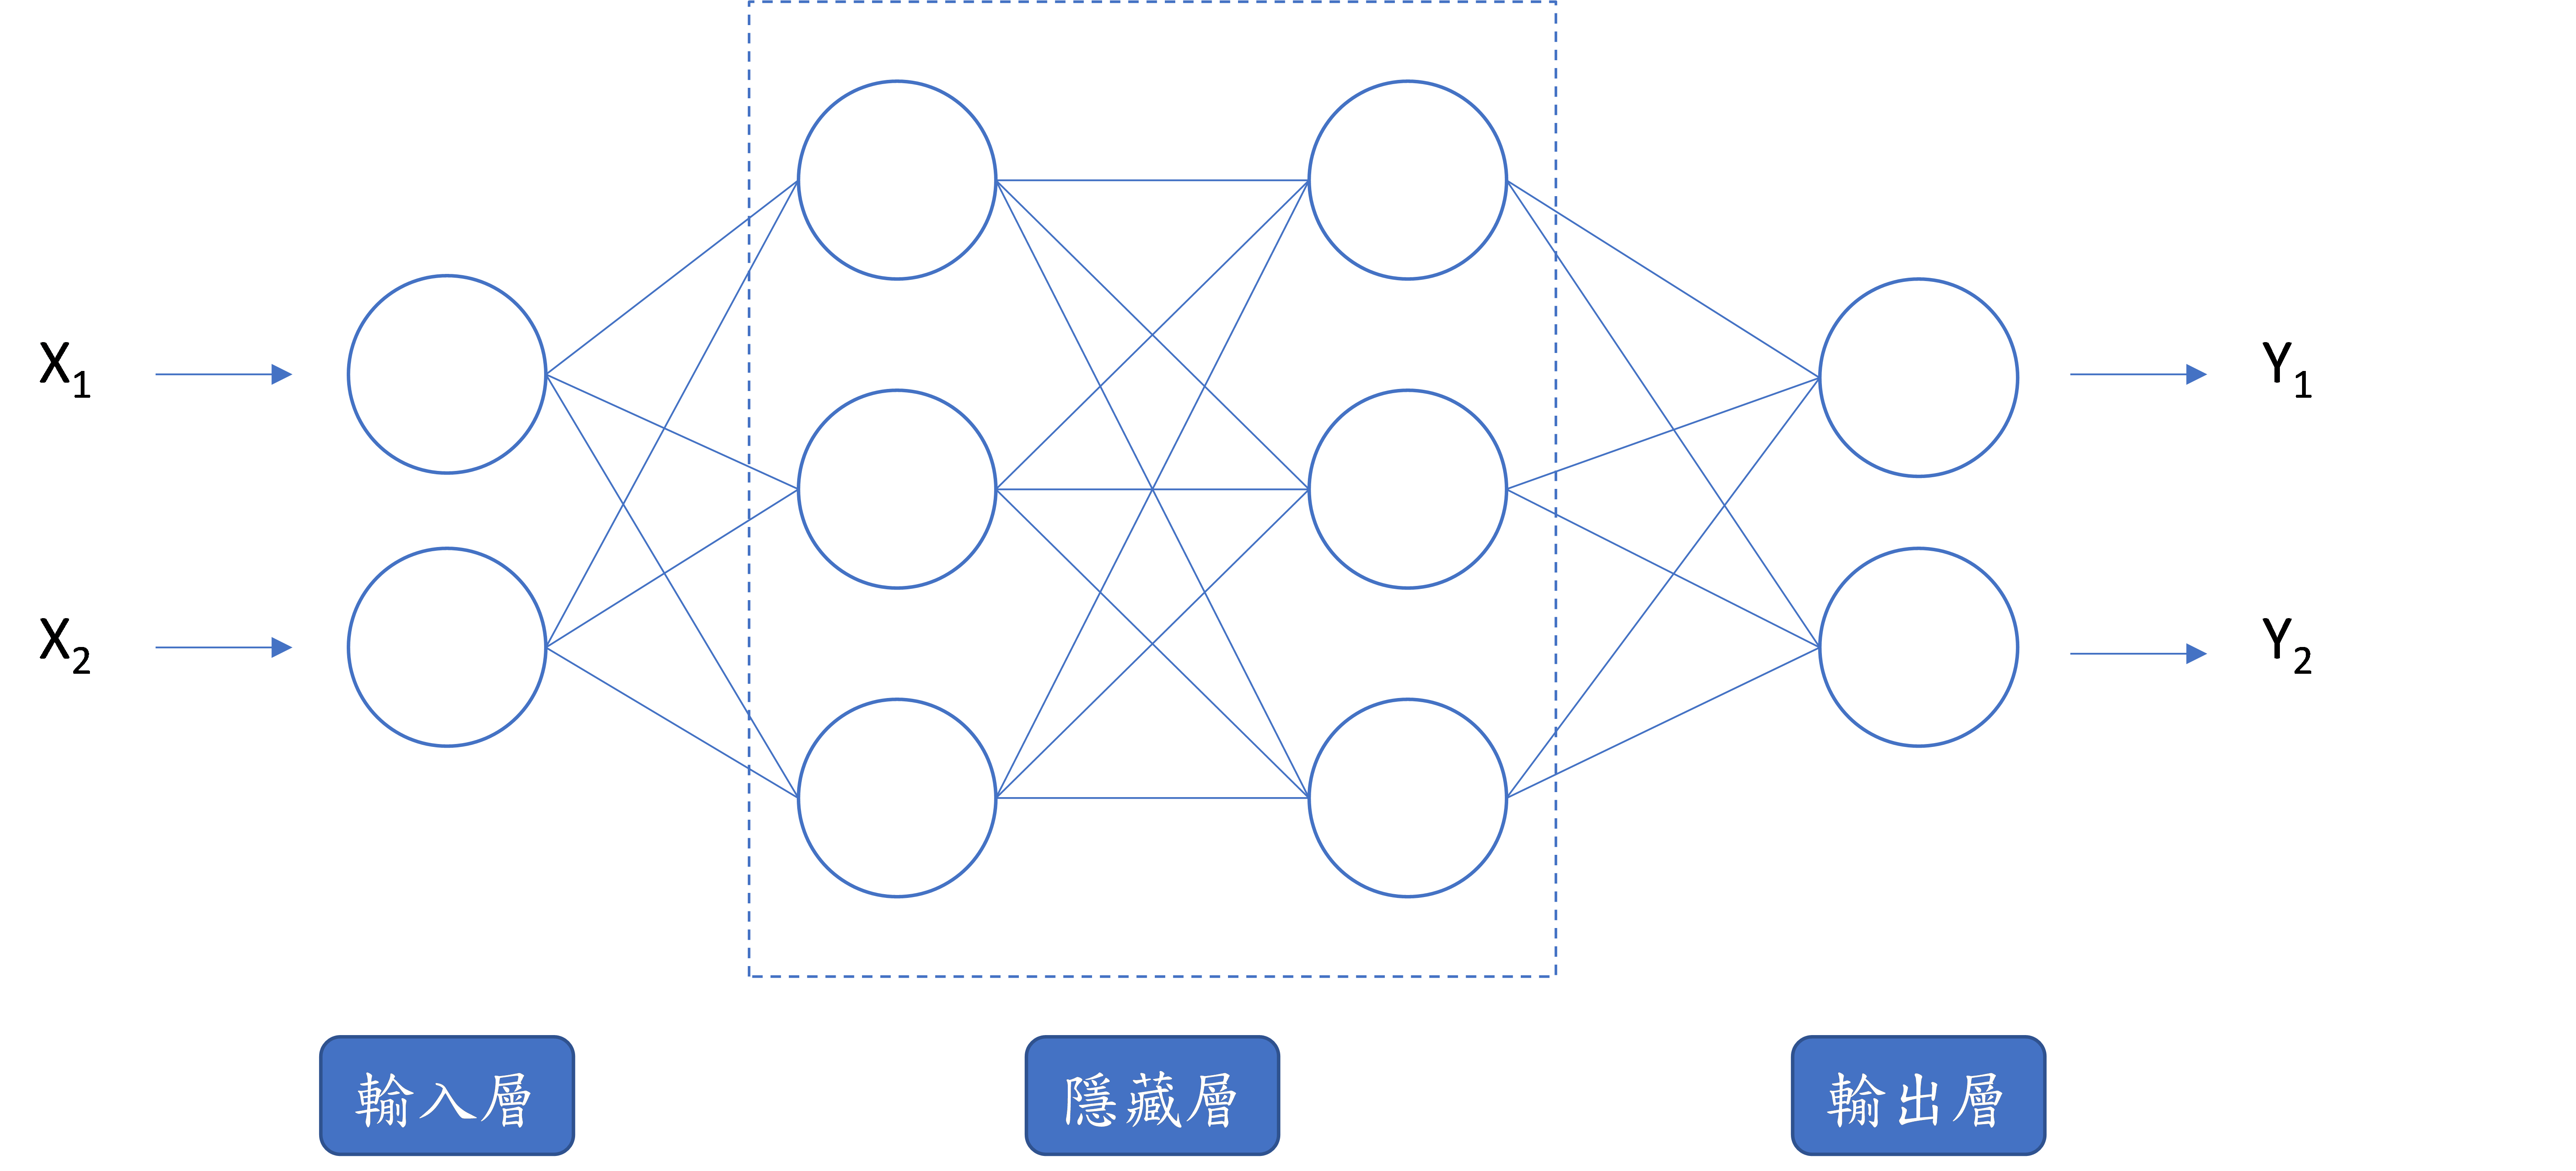

In [ ]:
#zeros-->全部為0的矩陣
pred = np.zeros((train_features.shape[0], 206)) #建立二維陣列 23814rows * 206columns(多分類目標)
pe = np.zeros((test_features.shape[0], 206)) #建立二維陣列 3982rows * 206columns(多分類目標)
train_features = train_features.values
train_targets = train_targets.values

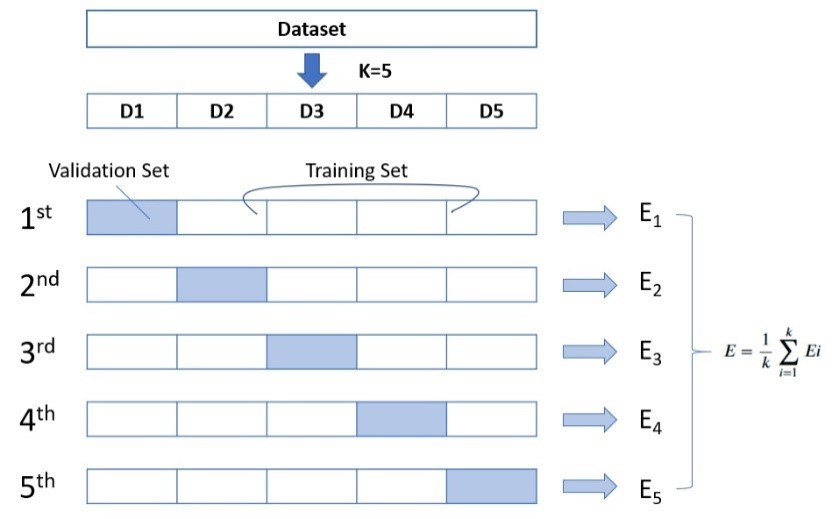

In [ ]:
n_split = 5 #Kfold分割成5個集合 
kfoldnumber= 0 

for train_index, validation_index in KFold(n_split).split(train_features):
    kfoldnumber += 1 
    print('Fold number: ',kfoldnumber) 
    #ReduceLROnPlateau-->當評價指標（損失，準確性）停止改進時，調整學習率
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')
    #說明:監控val_loss，在該數值等待3次，若無較好表現則調降學習率，但最低若為0.0001，則不在調降。
    net = build_model()
    #fit函數以訓練模型(輸入數據,標籤,...)
        #batch_size=128 每批資料量的大小設為128樣本
        #epoch=35 用訓練集中的全部樣本訓練35次(週期)
        #validation_data：形式為（X，y）的列表(tuple)，是指定的驗證集
    net.fit(train_features[train_index], train_targets[train_index], batch_size=128, epochs=35, 
            validation_data=(train_features[validation_index], train_targets[validation_index]), verbose=0, callbacks=[reduce_lr_loss])
    #evaluate函數按batch計算在某些輸入數據上模型的誤差
    print("train", net.evaluate(train_features[train_index], train_targets[train_index], verbose=0, batch_size=128))#訓練數據與訓練標籤
    print("val", net.evaluate(train_features[validation_index], train_targets[validation_index], verbose=0, batch_size=128))#驗證數據與驗證標籤
    #predict函數按batch獲得輸入數據對應的輸出
    print("predict val...")
    pred[validation_index] = net.predict(train_features[validation_index], batch_size=128, verbose=0)
    print("predict test...")
    pe += net.predict(test_features, batch_size=128, verbose=0) / n_split  

In [ ]:
pe.shape
columns = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
del columns['sig_id']
sub = pd.DataFrame(data=pe, columns=columns.columns)#資料表格建立

In [ ]:
sample = pd.read_csv('../input/lish-moa/sample_submission.csv')
sub.insert(0, column = 'sig_id', value=sample['sig_id']) #增加sig_id欄位
sub.to_csv('submission.csv', index=False)